In [164]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import math
import numpy as np
import scipy.stats as stats
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
import matplotlib.cm as cm



# Analisis exploratorio

In [127]:
ruta_archivo = '/Users/juanluis/Documents/educacion/U/semestres/semestre_10/Aprendizaje estadístico/Datos/ecobici_2024_03.csv'
df = pd.read_csv(ruta_archivo)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
# crear variable de fecha
df['fecha_hora_retiro'] = pd.to_datetime(df['fecha_retiro'] + ' ' + df['hora_retiro'], format="%d/%m/%Y %H:%M:%S", dayfirst=True, errors='coerce')
df['fecha_hora_arribo'] = pd.to_datetime(df['fecha_arribo'] + ' ' + df['hora_arribo'],  format="%d/%m/%Y %H:%M:%S", dayfirst=True, errors='coerce')

df['tiempo_trayecto'] = (df['fecha_hora_arribo'] - df['fecha_hora_retiro']).dt.total_seconds() / 60
df['dia_semana_num'] = df['fecha_hora_retiro'].dt.weekday


In [128]:
df.isna().sum()

genero_usuario            5
edad_usuario             22
bici                      0
ciclo_estacion_retiro     0
fecha_retiro              0
hora_retiro               0
ciclo_estacionarribo      0
fecha_arribo              0
hora_arribo               0
fecha_hora_retiro         0
fecha_hora_arribo         0
tiempo_trayecto           0
dia_semana_num            0
dtype: int64

In [129]:
df =  df.dropna()
df.dtypes

genero_usuario                   object
edad_usuario                    float64
bici                              int64
ciclo_estacion_retiro            object
fecha_retiro                     object
hora_retiro                      object
ciclo_estacionarribo             object
fecha_arribo                     object
hora_arribo                      object
fecha_hora_retiro        datetime64[ns]
fecha_hora_arribo        datetime64[ns]
tiempo_trayecto                 float64
dia_semana_num                    int32
dtype: object

In [130]:
variables = ['genero_usuario','edad_usuario', 'ciclo_estacion_retiro','hora_retiro', 'tiempo_trayecto', 'dia_semana_num' ]
data = df[variables]
data

,genero_usuario,edad_usuario,ciclo_estacion_retiro,hora_retiro,tiempo_trayecto,dia_semana_num
0,M,33.0,254,23:45:26,14.566667,3
1,F,36.0,088,23:32:11,27.866667,3
2,M,33.0,167,23:21:20,38.750000,3
3,F,38.0,576,23:01:00,59.133333,3
4,M,19.0,072,23:47:45,12.466667,3
...,...,...,...,...,...,...
1829758,F,30.0,536,23:33:51,25.616667,6
1829759,F,31.0,543,23:41:08,18.516667,6
1829760,M,28.0,217,23:34:00,25.683333,6
1829761,M,22.0,222,23:26:00,33.733333,6


/var/folders/ph/16ztjjw90vnfzgdjvcbzkyxr0000gn/T/ipykernel_9474/2448295446.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['hora_retiro_dt'] = pd.to_datetime(data['hora_retiro'], errors='coerce')
/var/folders/ph/16ztjjw90vnfzgdjvcbzkyxr0000gn/T/ipykernel_9474/2448295446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hora_retiro_dt'] = pd.to_datetime(data['hora_retiro'], errors='coerce')
/var/folders/ph/16ztjjw90vnfzgdjvcbzkyxr0000gn/T/ipykernel_9474/2448295446.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

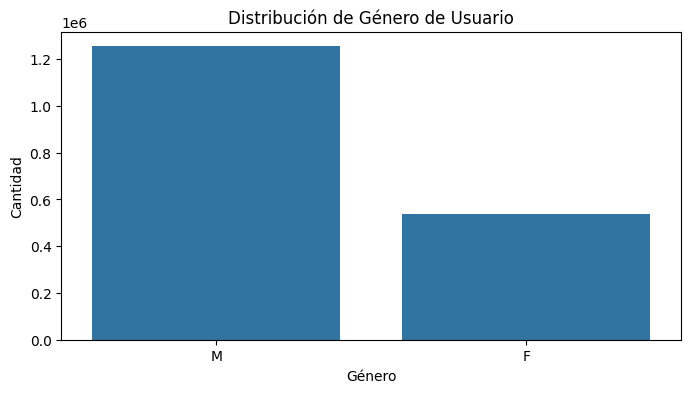

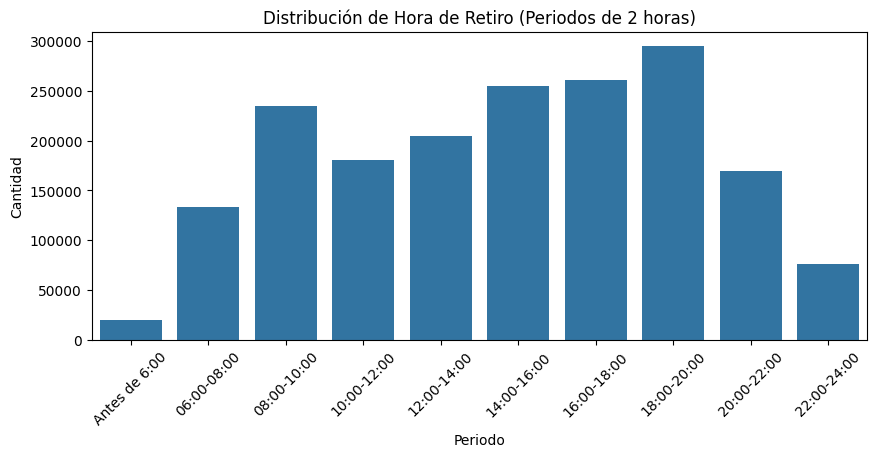

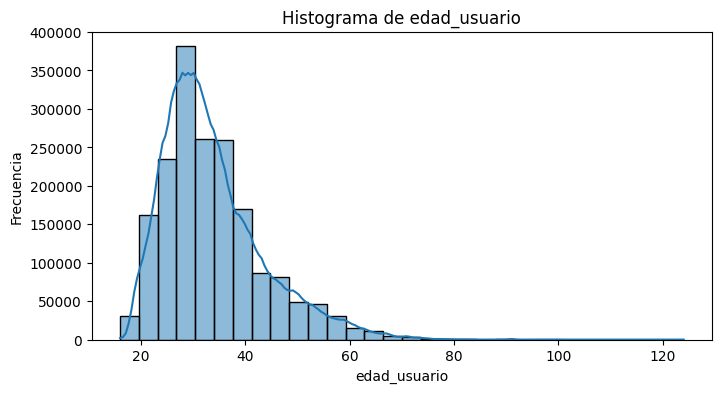

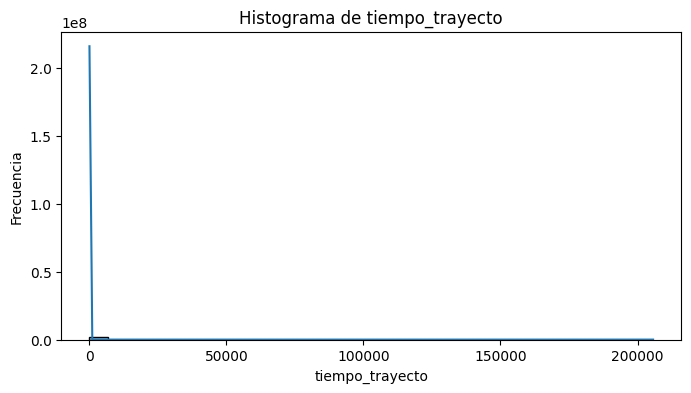

In [131]:
data['hora_retiro_dt'] = pd.to_datetime(data['hora_retiro'], errors='coerce')

# Extraer la hora (entera)
data['hora_retiro_hour'] = data['hora_retiro_dt'].dt.hour

# Función para cuantizar la hora en periodos de 2 horas a partir de las 6:00
def cuantizar_hora(hora):
    if pd.isna(hora):
        return np.nan
    if hora < 6:
        return "Antes de 6:00"
    else:
        # Calcular límite inferior del intervalo (de dos en dos)
        lb = ((hora - 6) // 2) * 2 + 6
        ub = lb + 2
        return f"{lb:02d}:00-{ub:02d}:00"

# Aplicar la función sobre la columna con la hora numérica
data['hora_retiro_periodo'] = data['hora_retiro_hour'].apply(cuantizar_hora)

# --- 4. Graficar gráficos de barras para las variables categóricas ---
# Gráfica de barras para 'genero_usuario'
plt.figure(figsize=(8, 4))
sns.countplot(data=data, x='genero_usuario', order=['M', 'F'])
plt.title("Distribución de Género de Usuario")
plt.xlabel("Género")
plt.ylabel("Cantidad")
plt.show()

# Gráfica de barras para 'hora_retiro_periodo'
# Para mantener el orden cronológico, filtramos las categorías (se ignora "Antes de 6:00" si existen)
orden_periodos = sorted(data['hora_retiro_periodo'].dropna().unique(),
                        key=lambda x: int(x.split(':')[0]) if x != "Antes de 6:00" else 0)
if "Antes de 6:00" in data['hora_retiro_periodo'].unique():
    orden_periodos = ["Antes de 6:00"] + orden_periodos

plt.figure(figsize=(10, 4))
sns.countplot(data=data, x='hora_retiro_periodo', order=orden_periodos)
plt.title("Distribución de Hora de Retiro (Periodos de 2 horas)")
plt.xlabel("Periodo")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.show()

# --- 5. Graficar histogramas para las variables numéricas ---
# Definimos las variables numéricas. (Nota: 'ciclo_estacionarribo' aparece dos veces; se toma una sola vez)
numeric_vars = ['edad_usuario',  'tiempo_trayecto']

for var in numeric_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=data, x=var, kde=True, bins=30)
    plt.title(f"Histograma de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.show()

In [132]:
df_largos = data[data['tiempo_trayecto'] > 60]
df_largos

,genero_usuario,edad_usuario,ciclo_estacion_retiro,hora_retiro,tiempo_trayecto,dia_semana_num,hora_retiro_dt,hora_retiro_hour,hora_retiro_periodo
151,M,27.0,299,18:33:02,339.716667,3,2025-04-10 18:33:02,18,18:00-20:00
262,F,35.0,593,23:21:14,60.800000,3,2025-04-10 23:21:14,23,22:00-24:00
380,M,32.0,173,21:05:06,207.100000,3,2025-04-10 21:05:06,21,20:00-22:00
474,M,28.0,041,23:51:29,60.383333,3,2025-04-10 23:51:29,23,22:00-24:00
477,M,26.0,138,23:45:52,66.216667,3,2025-04-10 23:45:52,23,22:00-24:00
...,...,...,...,...,...,...,...,...,...
1828753,M,25.0,531,21:35:22,65.916667,6,2025-04-10 21:35:22,21,20:00-22:00
1829120,F,27.0,027,21:35:11,88.166667,6,2025-04-10 21:35:11,21,20:00-22:00
1829122,M,41.0,027,21:35:06,88.366667,6,2025-04-10 21:35:06,21,20:00-22:00
1829190,M,20.0,028,21:17:52,111.316667,6,2025-04-10 21:17:52,21,20:00-22:00


Parece que los trayectos largos hay muchos individuos que toman y dejan la bicicleta en la misma estacion

In [133]:
dfcirc = df[df['ciclo_estacion_retiro']==df['ciclo_estacionarribo']]

In [134]:
dfcirc= dfcirc[variables]
dfcirc

,genero_usuario,edad_usuario,ciclo_estacion_retiro,hora_retiro,tiempo_trayecto,dia_semana_num
20,M,23.0,574,23:48:39,12.883333,3
175,M,25.0,148,00:10:39,5.150000,4
232,M,24.0,003,00:08:56,10.050000,4
285,M,31.0,291,23:53:09,31.083333,3
329,F,25.0,057,00:07:28,20.300000,4
...,...,...,...,...,...,...
1829705,F,34.0,147,23:45:24,7.733333,6
1829726,M,35.0,053,23:10:19,45.083333,6
1829728,M,39.0,169,23:18:33,37.183333,6
1829758,F,30.0,536,23:33:51,25.616667,6


In [135]:
LargosCirc =  dfcirc[dfcirc['tiempo_trayecto'] > 60]
LargosCirc


,genero_usuario,edad_usuario,ciclo_estacion_retiro,hora_retiro,tiempo_trayecto,dia_semana_num
477,M,26.0,138,23:45:52,66.216667,3
511,M,22.0,141,00:29:09,94.066667,4
514,F,21.0,520,21:11:34,396.250000,3
16657,M,40.0,001,09:19:42,64.133333,4
21192,F,18.0,022,09:55:18,126.533333,4
...,...,...,...,...,...,...
1826787,M,19.0,194,20:07:27,69.600000,6
1827380,M,23.0,259,17:29:43,248.700000,6
1827964,M,21.0,033,20:52:24,70.233333,6
1829190,M,20.0,028,21:17:52,111.316667,6


In [138]:
df

,genero_usuario,edad_usuario,bici,ciclo_estacion_retiro,fecha_retiro,hora_retiro,ciclo_estacionarribo,fecha_arribo,hora_arribo,fecha_hora_retiro,fecha_hora_arribo,tiempo_trayecto,dia_semana_num
0,M,33.0,4044731,254,29/02/2024,23:45:26,546,01/03/2024,00:00:00,2024-02-29 23:45:26,2024-03-01 00:00:00,14.566667,3
1,F,36.0,6611925,088,29/02/2024,23:32:11,103,01/03/2024,00:00:03,2024-02-29 23:32:11,2024-03-01 00:00:03,27.866667,3
2,M,33.0,3193679,167,29/02/2024,23:21:20,112,01/03/2024,00:00:05,2024-02-29 23:21:20,2024-03-01 00:00:05,38.750000,3
3,F,38.0,6066906,576,29/02/2024,23:01:00,636,01/03/2024,00:00:08,2024-02-29 23:01:00,2024-03-01 00:00:08,59.133333,3
4,M,19.0,6435168,072,29/02/2024,23:47:45,327,01/03/2024,00:00:13,2024-02-29 23:47:45,2024-03-01 00:00:13,12.466667,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829758,F,30.0,8441289,536,31/03/2024,23:33:51,536,31/03/2024,23:59:28,2024-03-31 23:33:51,2024-03-31 23:59:28,25.616667,6
1829759,F,31.0,2991446,543,31/03/2024,23:41:08,257,31/03/2024,23:59:39,2024-03-31 23:41:08,2024-03-31 23:59:39,18.516667,6
1829760,M,28.0,4665949,217,31/03/2024,23:34:00,217,31/03/2024,23:59:41,2024-03-31 23:34:00,2024-03-31 23:59:41,25.683333,6
1829761,M,22.0,6748404,222,31/03/2024,23:26:00,017,31/03/2024,23:59:44,2024-03-31 23:26:00,2024-03-31 23:59:44,33.733333,6


# Separamos las poblaciones y las normalizanoms y centramos

In [139]:
from sklearn.preprocessing import LabelEncoder
# agregando versiones numericas de algunas variables
le = LabelEncoder()
#data['hora_retiro_dt'] = pd.to_datetime(df['hora_retiro'], errors='coerce')

df['hora_retiro_hour'] = df['fecha_hora_retiro'].dt.hour

# convertimos todas las variables a numericas
df['genero_num'] = le.fit_transform(df['genero_usuario'])

# Caso 1: Si el valor es un único número (ej: "123")
df['estacion_num'] = pd.to_numeric(df['ciclo_estacion_retiro'], errors='coerce')

# Caso 2: Si el valor es una lista (ej: "134-135-510"), tomar el primer elemento
df['estacion_num'] = df['ciclo_estacion_retiro'].str.split('-').str[0].astype(float)

In [140]:
#Separa los datos:
dfCirc = df[df['ciclo_estacion_retiro']==df['ciclo_estacionarribo']]
dfNonCirc = df[df['ciclo_estacion_retiro']!=df['ciclo_estacionarribo']]
# Seleccionar variables numericas
varnum = ['genero_num','edad_usuario','estacion_num','hora_retiro_hour','tiempo_trayecto', 'dia_semana_num']

# normalizar ambos (dfCirc, dfNonCirc)

# boox plots de ambos

# Eliminar atípicos (no olvides contar los atípicos eliminados)

# pair plots de ambas distribuciones 

#correlaciones lineales ambas distribuciones (en forma de mapa de calor)






,genero_usuario,edad_usuario,bici,ciclo_estacion_retiro,fecha_retiro,hora_retiro,ciclo_estacionarribo,fecha_arribo,hora_arribo,fecha_hora_retiro,fecha_hora_arribo,tiempo_trayecto,dia_semana_num,hora_retiro_hour,genero_num,estacion_num
0,M,33.0,4044731,254,29/02/2024,23:45:26,546,01/03/2024,00:00:00,2024-02-29 23:45:26,2024-03-01 00:00:00,14.566667,3,23,2,254.0
1,F,36.0,6611925,088,29/02/2024,23:32:11,103,01/03/2024,00:00:03,2024-02-29 23:32:11,2024-03-01 00:00:03,27.866667,3,23,1,88.0
2,M,33.0,3193679,167,29/02/2024,23:21:20,112,01/03/2024,00:00:05,2024-02-29 23:21:20,2024-03-01 00:00:05,38.750000,3,23,2,167.0
3,F,38.0,6066906,576,29/02/2024,23:01:00,636,01/03/2024,00:00:08,2024-02-29 23:01:00,2024-03-01 00:00:08,59.133333,3,23,1,576.0
4,M,19.0,6435168,072,29/02/2024,23:47:45,327,01/03/2024,00:00:13,2024-02-29 23:47:45,2024-03-01 00:00:13,12.466667,3,23,2,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829758,F,30.0,8441289,536,31/03/2024,23:33:51,536,31/03/2024,23:59:28,2024-03-31 23:33:51,2024-03-31 23:59:28,25.616667,6,23,1,536.0
1829759,F,31.0,2991446,543,31/03/2024,23:41:08,257,31/03/2024,23:59:39,2024-03-31 23:41:08,2024-03-31 23:59:39,18.516667,6,23,1,543.0
1829760,M,28.0,4665949,217,31/03/2024,23:34:00,217,31/03/2024,23:59:41,2024-03-31 23:34:00,2024-03-31 23:59:41,25.683333,6,23,2,217.0
1829761,M,22.0,6748404,222,31/03/2024,23:26:00,017,31/03/2024,23:59:44,2024-03-31 23:26:00,2024-03-31 23:59:44,33.733333,6,23,2,222.0


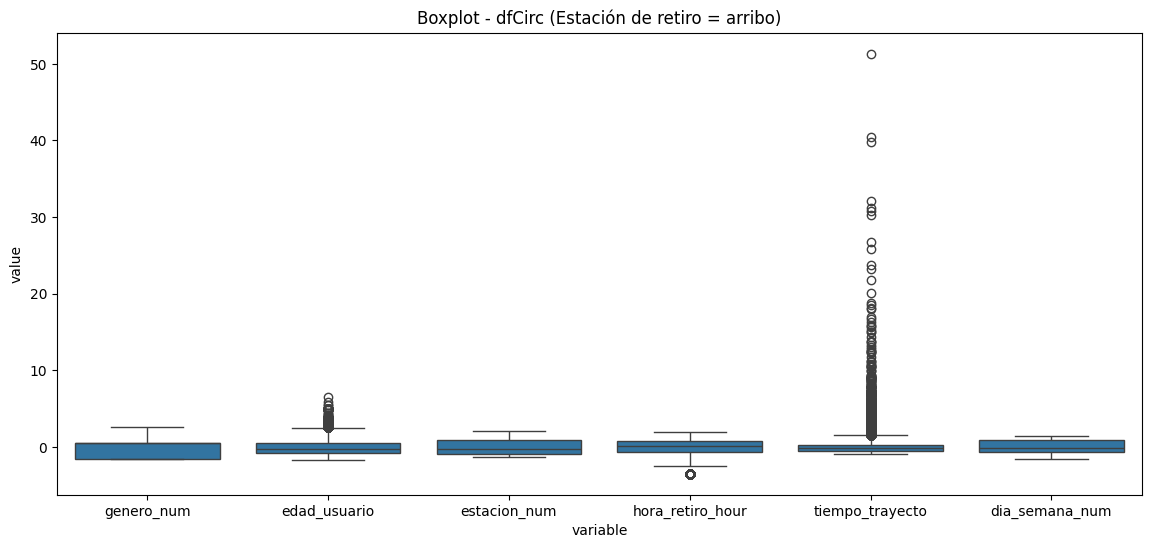

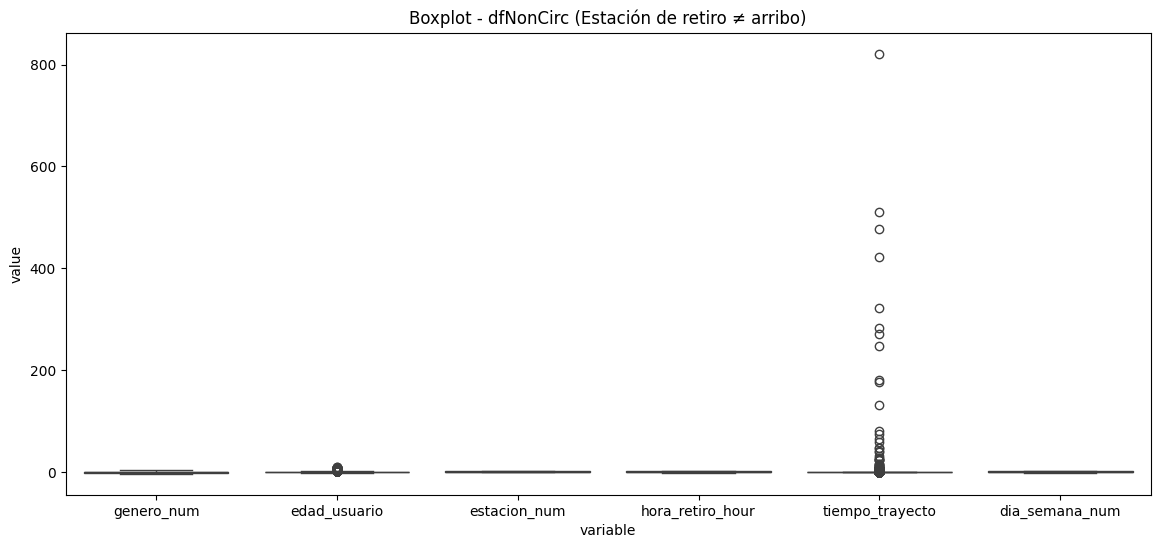

Outliers eliminados en dfCirc: 1402
Outliers eliminados en dfNonCirc: 28371


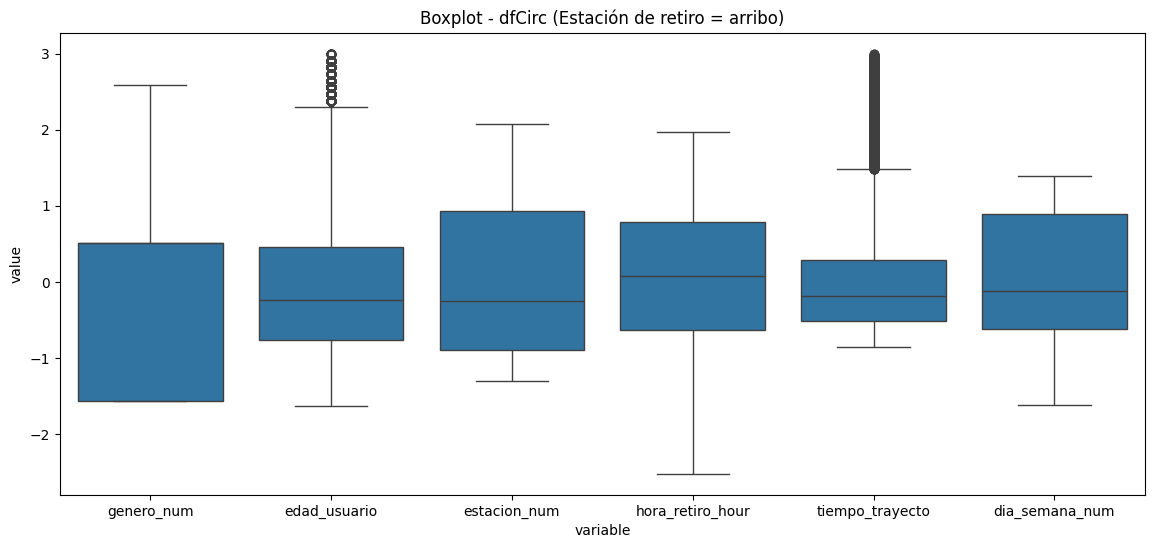

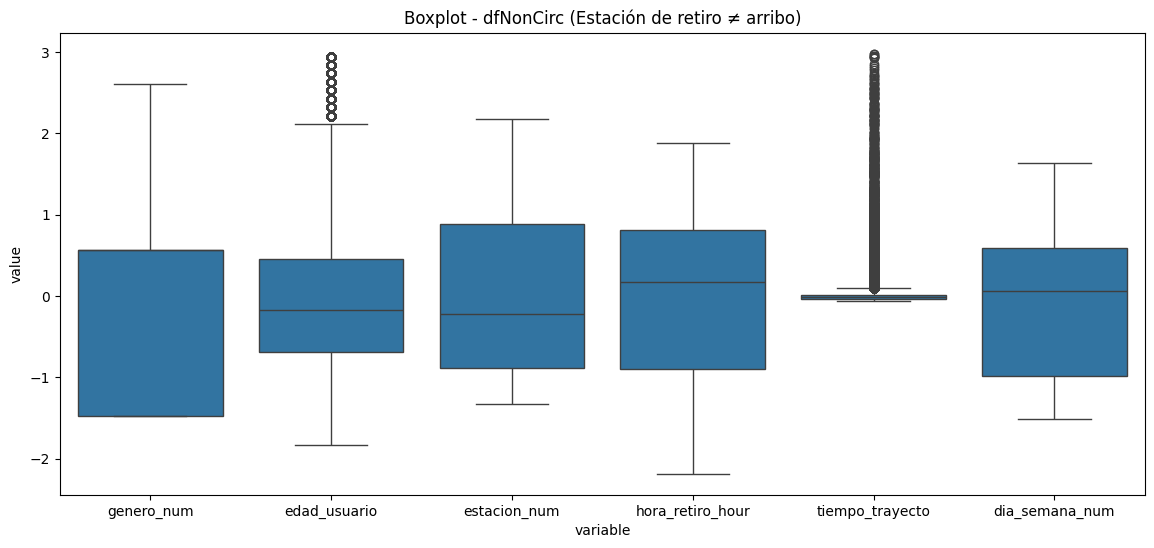

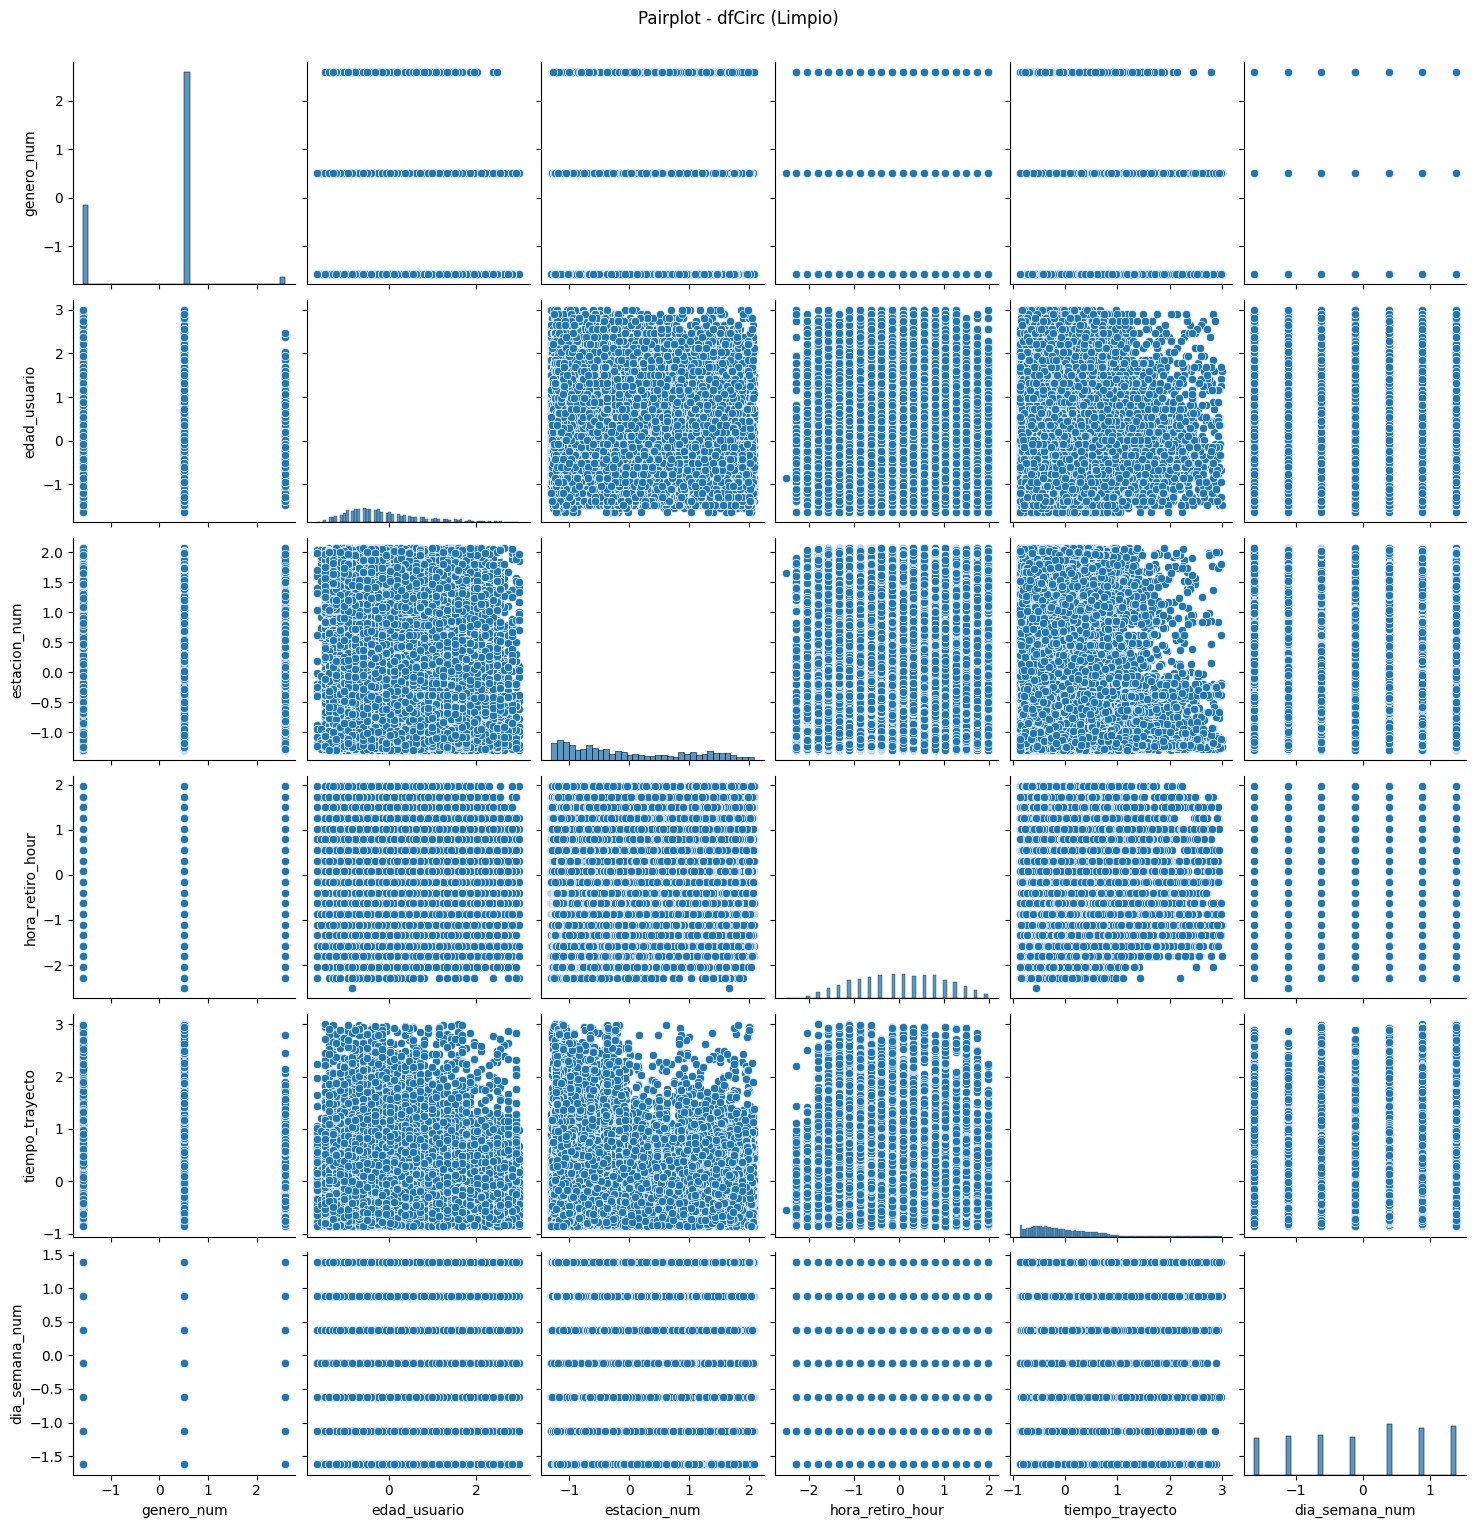

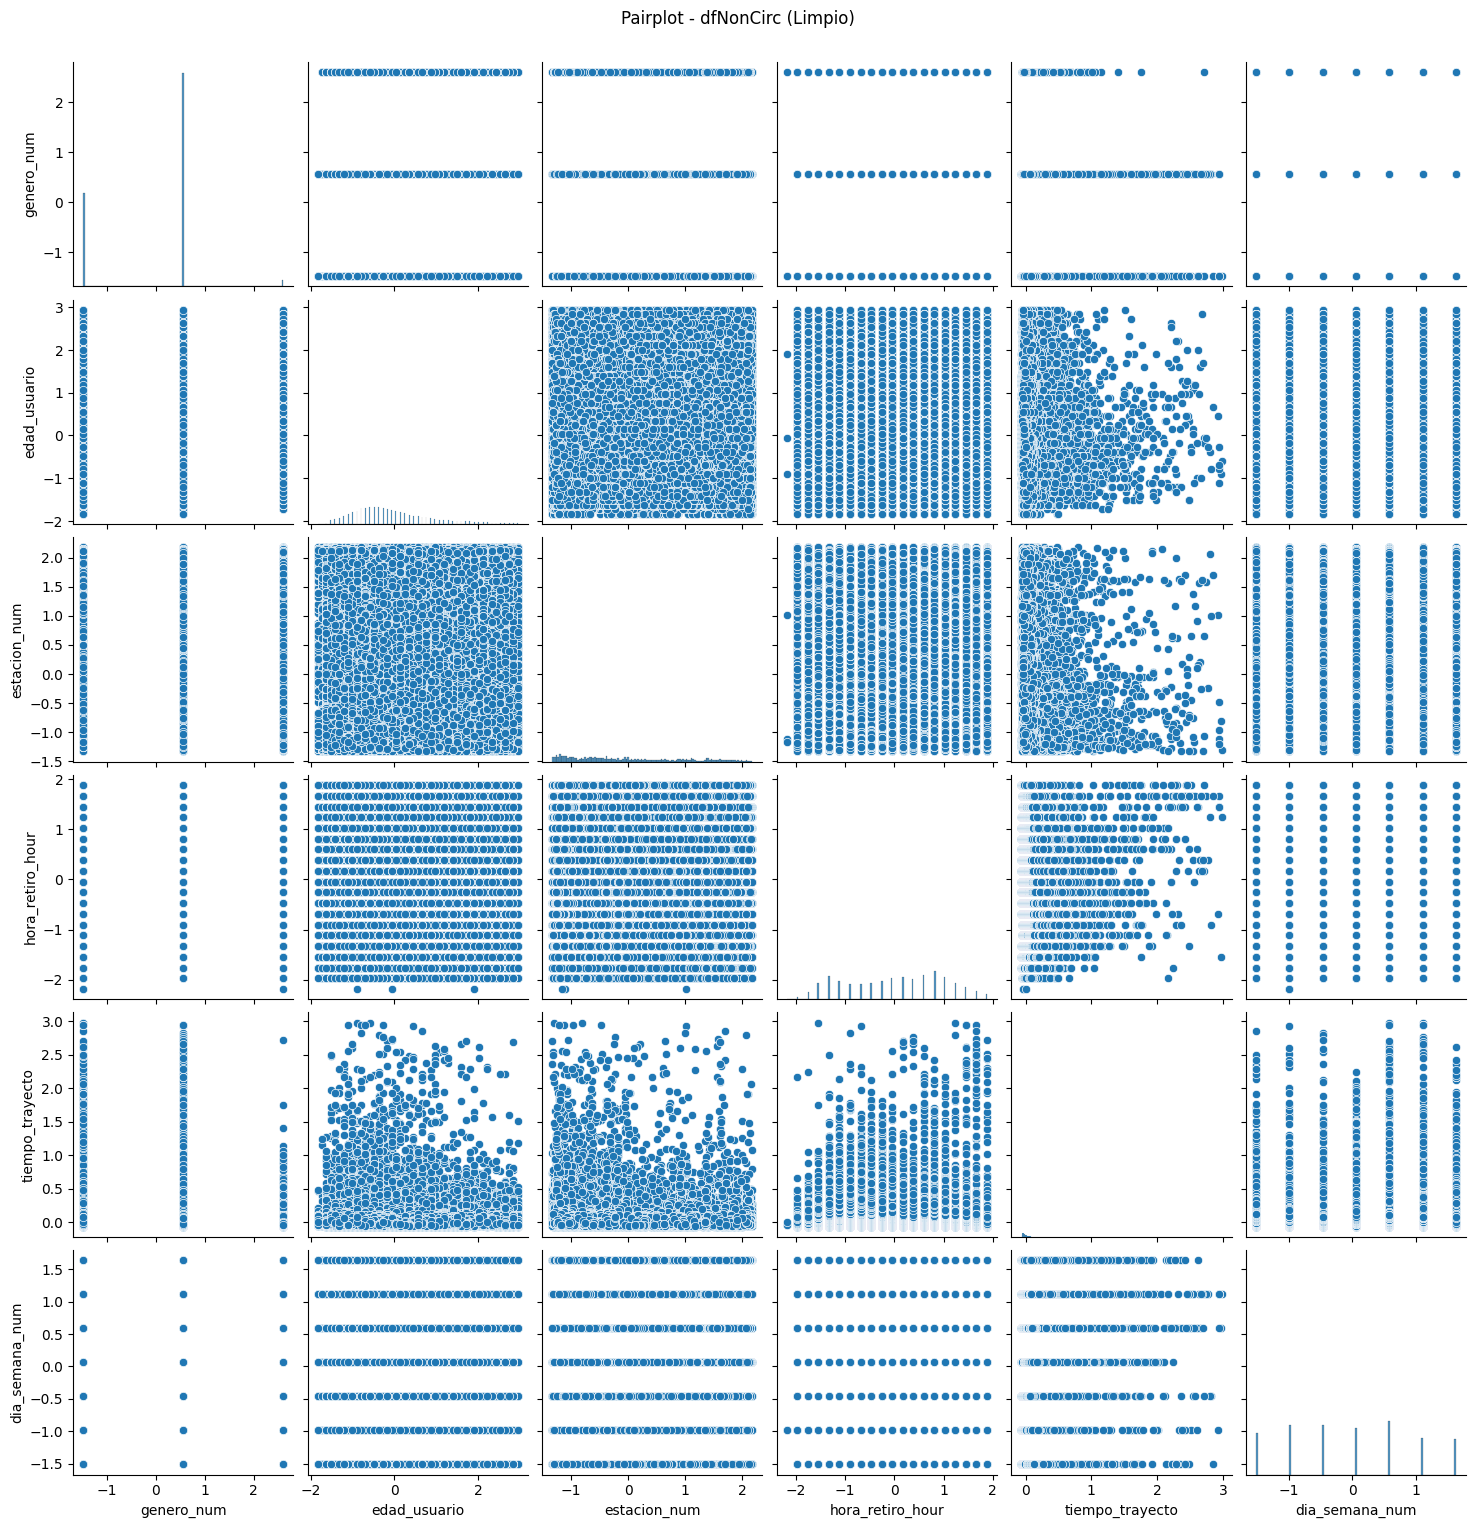

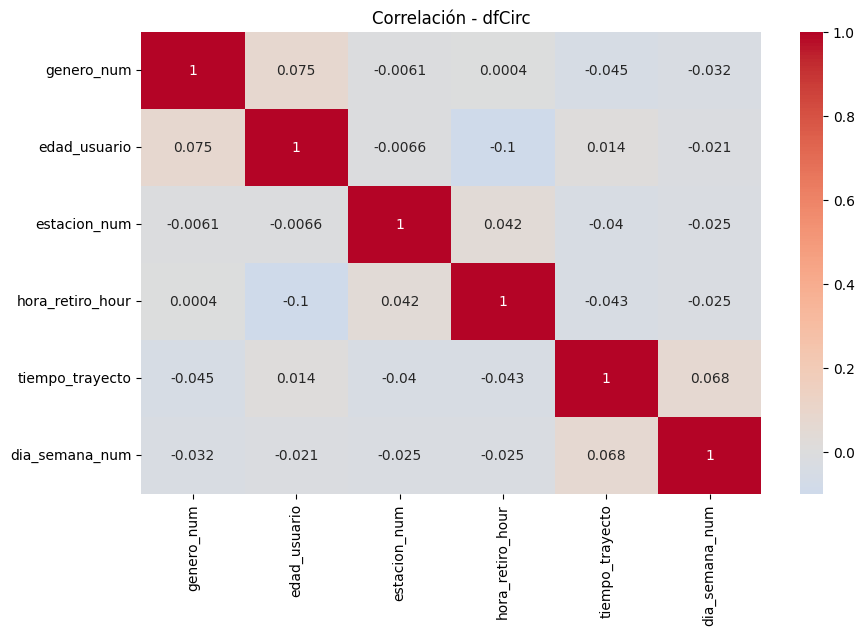

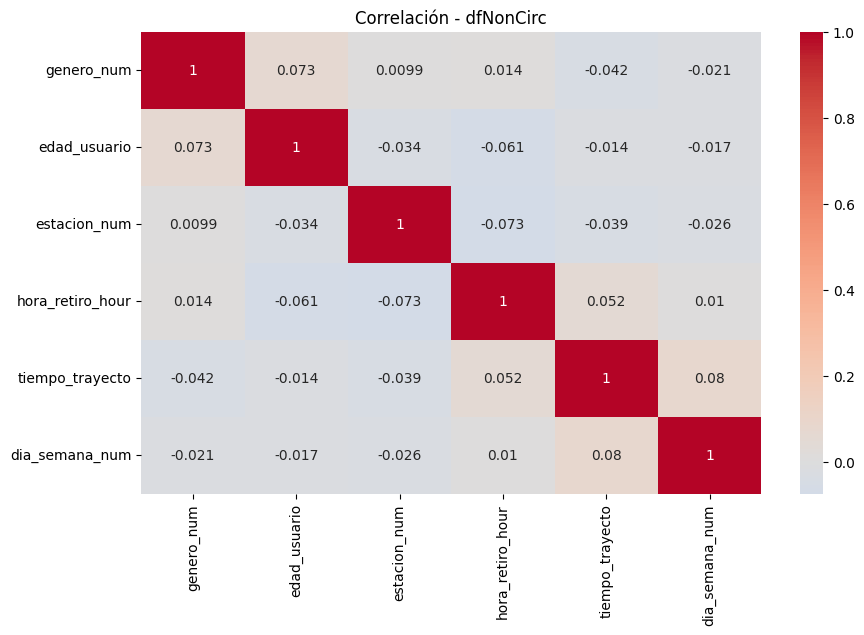

In [182]:

# --- 1. Separar los datos ---
dfCirc = df[df['ciclo_estacion_retiro'] == df['ciclo_estacionarribo']].copy()
dfNonCirc = df[df['ciclo_estacion_retiro'] != df['ciclo_estacionarribo']].copy()

# --- 2. Seleccionar variables numéricas ---
varnum = ['genero_num','edad_usuario','estacion_num','hora_retiro_hour','tiempo_trayecto','dia_semana_num']

# --- 3. Normalizar ambos ---
scaler = StandardScaler()
dfCirc_norm = dfCirc.copy()
dfNonCirc_norm = dfNonCirc.copy()
dfCirc_norm[varnum] = scaler.fit_transform(dfCirc[varnum])
dfNonCirc_norm[varnum] = scaler.fit_transform(dfNonCirc[varnum])

# --- 4. Boxplots para ambos ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=pd.melt(dfCirc_norm[varnum]), x='variable', y='value')
plt.title('Boxplot - dfCirc (Estación de retiro = arribo)')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=pd.melt(dfNonCirc_norm[varnum]), x='variable', y='value')
plt.title('Boxplot - dfNonCirc (Estación de retiro ≠ arribo)')
plt.show()

# --- 5. Eliminar atípicos (Z-score > 3 o < -3) ---
def remove_outliers(df, columns, threshold=3):
    mask = ((df[columns] < threshold) & (df[columns] > -threshold)).all(axis=1)
    removed = len(df) - mask.sum()
    return df[mask].reset_index(drop=True), removed

dfCirc_clean, out_circ = remove_outliers(dfCirc_norm, varnum)
dfNonCirc_clean, out_noncirc = remove_outliers(dfNonCirc_norm, varnum)

print(f"Outliers eliminados en dfCirc: {out_circ}")
print(f"Outliers eliminados en dfNonCirc: {out_noncirc}")


plt.figure(figsize=(14, 6))
sns.boxplot(data=pd.melt(dfCirc_clean[varnum]), x='variable', y='value')
plt.title('Boxplot - dfCirc (Estación de retiro = arribo)')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=pd.melt(dfNonCirc_clean[varnum]), x='variable', y='value')
plt.title('Boxplot - dfNonCirc (Estación de retiro ≠ arribo)')
plt.show()

# --- 6. Pairplot de ambas distribuciones ---
sns.pairplot(dfCirc_clean[varnum])
plt.suptitle("Pairplot - dfCirc (Limpio)", y=1.02)
plt.show()

sns.pairplot(dfNonCirc_clean[varnum])
plt.suptitle("Pairplot - dfNonCirc (Limpio)", y=1.02)
plt.show()

# --- 7. Mapas de calor de correlaciones ---
plt.figure(figsize=(10, 6))
sns.heatmap(dfCirc_clean[varnum].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlación - dfCirc")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(dfNonCirc_clean[varnum].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlación - dfNonCirc")
plt.show()


# Preguntas
* ¿Son diferentes las poblaciones de usuarios que hacen trayectos circulares de la que no?
* ¿Habrab clases diferenciadas dentro de los trayectos circulares?
* ¿Quienes y dondes se efectuan ese tipo de recorridos?

# Prueba de hipótesis

### Muestreo del mismo tamaño (10 0000 datos)


In [154]:
muestra_circ.dtypes

genero_num          float64
edad_usuario        float64
estacion_num        float64
hora_retiro_hour    float64
tiempo_trayecto     float64
dia_semana_num      float64
dtype: object

In [157]:
# MUESTRAS
muestra_circ = dfCirc_clean.sample(n=10000, random_state=313)[varnum]
muestra_lin = dfNonCirc_clean.sample(n=10000, random_state=313)[varnum]


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [161]:

# Tabla para almacenar los resultados
results = []

for var in varnum:
    stat, pval = ks_2samp(muestra_circ[var].dropna(), muestra_lin[var].dropna())
    results.append({
        "Variable": var,
        "KS": stat,
        "p-valOR": pval,
        
    })


ks_df = pd.DataFrame(results)
display(ks_df)


,Variable,KS,p-valOR
0,genero_num,0.6835,0.000000e+00
1,edad_usuario,0.0564,3.017552e-14
2,estacion_num,0.0352,8.300516e-06
3,hora_retiro_hour,0.1018,1.652921e-45
4,tiempo_trayecto,0.5885,0.000000e+00
5,dia_semana_num,0.1273,5.427127e-71


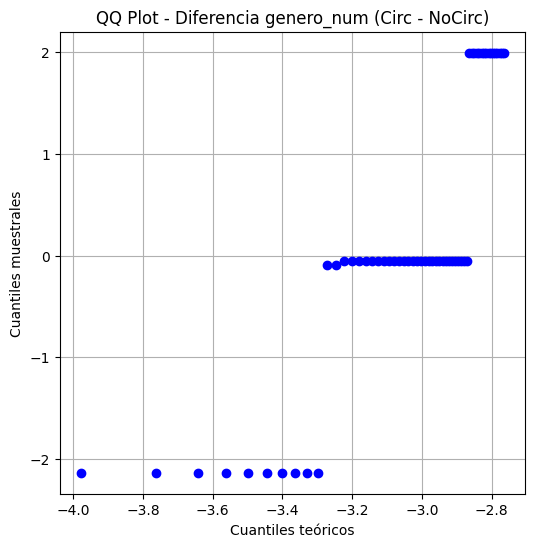

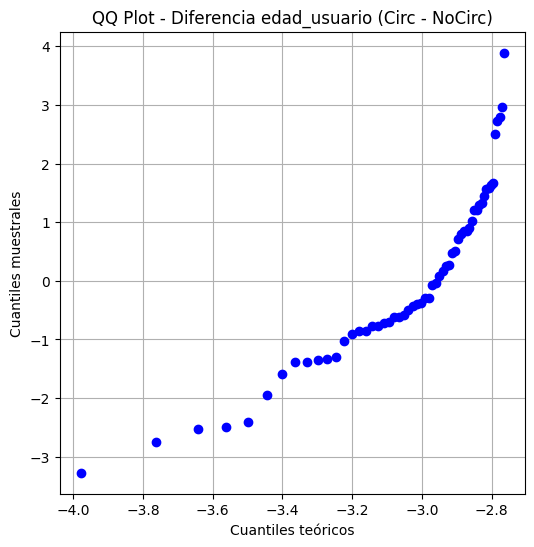

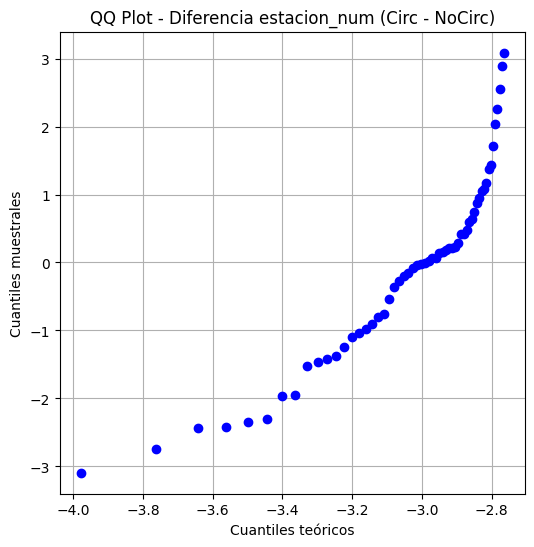

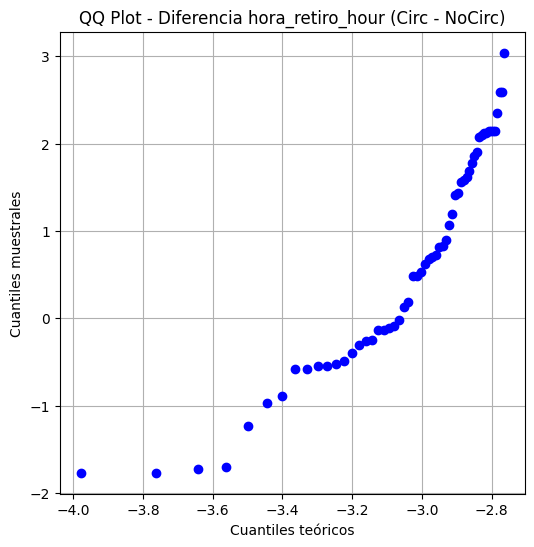

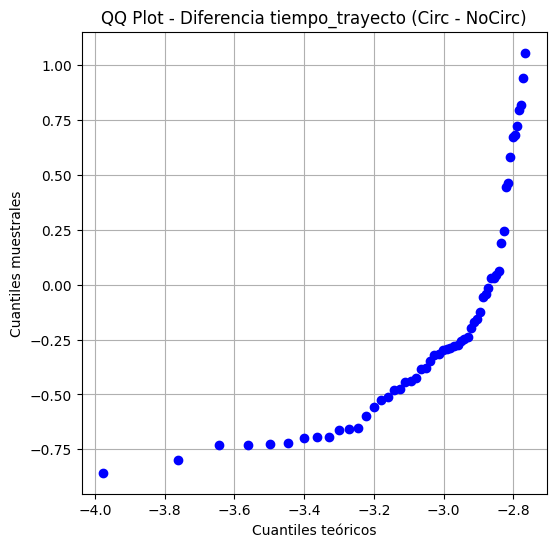

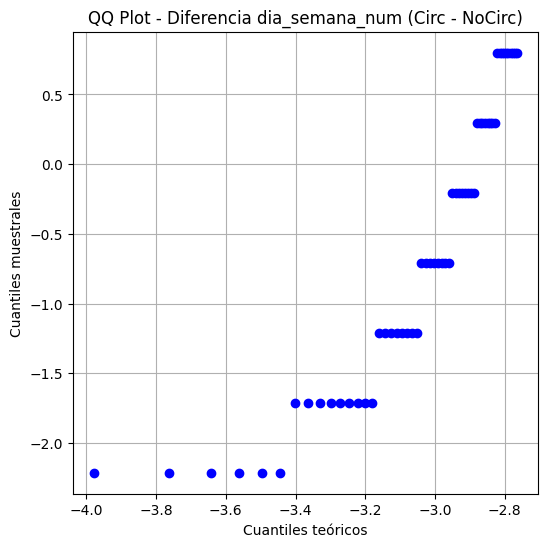

In [160]:
# Generar QQ plots para cada variable comparando muestra_circ vs muestra_lin
for var in varnum:
    plt.figure(figsize=(6, 6))
    stats.probplot(muestra_circ[var].dropna() - muestra_lin[var].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ Plot - Diferencia {var} (Circ - NoCirc)")
    plt.xlabel("Cuantiles teóricos")
    plt.ylabel("Cuantiles muestrales")
    plt.grid(True)
    plt.show()


# PCA

In [166]:
dfCirc_clean


,genero_usuario,edad_usuario,bici,ciclo_estacion_retiro,fecha_retiro,hora_retiro,ciclo_estacionarribo,fecha_arribo,hora_arribo,fecha_hora_retiro,fecha_hora_arribo,tiempo_trayecto,dia_semana_num,hora_retiro_hour,genero_num,estacion_num
0,M,-1.026357,7252778,574,29/02/2024,23:48:39,574,01/03/2024,00:01:32,2024-02-29 23:48:39,2024-03-01 00:01:32,-0.424818,-0.118680,1.970642,0.510515,1.428954
1,M,-0.327210,7089436,291,29/02/2024,23:53:09,291,01/03/2024,00:24:14,2024-02-29 23:53:09,2024-03-01 00:24:14,0.307908,-0.118680,1.970642,0.510515,0.080978
2,M,-0.764177,5024161,138,29/02/2024,23:45:52,138,01/03/2024,00:52:05,2024-02-29 23:45:52,2024-03-01 00:52:05,1.722365,-0.118680,1.970642,0.510515,-0.647786
3,M,1.770231,2717288,427,01/03/2024,05:08:56,427,01/03/2024,05:15:54,2024-03-01 05:08:56,2024-03-01 05:15:54,-0.663022,0.383459,-2.284058,0.510515,0.728769
4,M,0.808904,7862170,257,01/03/2024,05:29:28,257,01/03/2024,05:45:24,2024-03-01 05:29:28,2024-03-01 05:45:24,-0.302026,0.383459,-2.284058,0.510515,-0.080969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51443,F,-0.065030,4712956,147,31/03/2024,23:45:24,147,31/03/2024,23:53:08,2024-03-31 23:45:24,2024-03-31 23:53:08,-0.632156,1.387737,1.970642,-1.571814,-0.604918
51444,M,0.022363,4255840,053,31/03/2024,23:10:19,053,31/03/2024,23:55:24,2024-03-31 23:10:19,2024-03-31 23:55:24,0.871544,1.387737,1.970642,0.510515,-1.052655
51445,M,0.371937,5649975,169,31/03/2024,23:18:33,169,31/03/2024,23:55:44,2024-03-31 23:18:33,2024-03-31 23:55:44,0.553492,1.387737,1.970642,0.510515,-0.500128
51446,F,-0.414603,8441289,536,31/03/2024,23:33:51,536,31/03/2024,23:59:28,2024-03-31 23:33:51,2024-03-31 23:59:28,0.087822,1.387737,1.970642,-1.571814,1.247954


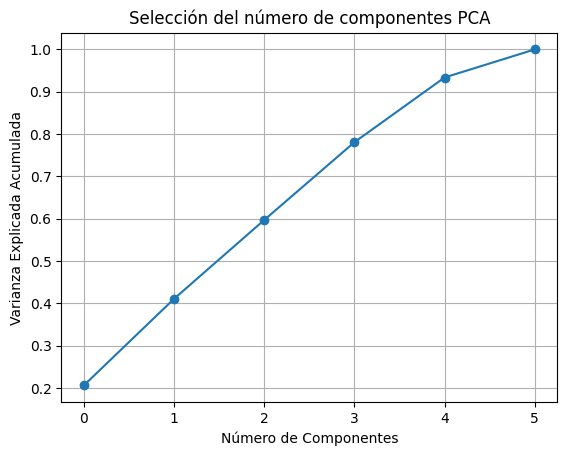

In [188]:
X = dfCirc_clean[varnum]
pca = PCA()
pca.fit(X)

# Graficar varianza explicada acumulada
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Selección del número de componentes PCA")
plt.grid()
plt.show()


In [174]:
pca = PCA(n_components=3)
X_pca = pca.fit(X)


cargas_pca = pd.DataFrame(pca.components_, columns=[f"Var{i+1}" for i in range(X.shape[1])], index=[f"PC{i+1}" for i in range(3)])

# Mostrar las cargas de los 5 primeros componentes
print(cargas_pca)

         Var1      Var2      Var3      Var4      Var5      Var6
PC1  0.635003  0.475900 -0.364718 -0.466935  0.001384 -0.138711
PC2 -0.392741 -0.028717 -0.537524 -0.339078  0.081207  0.659113
PC3  0.115117  0.249228  0.743177 -0.323494  0.016195  0.517118


### Interpretacion

* componente 1: Genero + edad - hora retiro
* componente 2: - media (estacion retiro + hora retiro)
* componente 3: estacion_num - hora retiro + diasem 

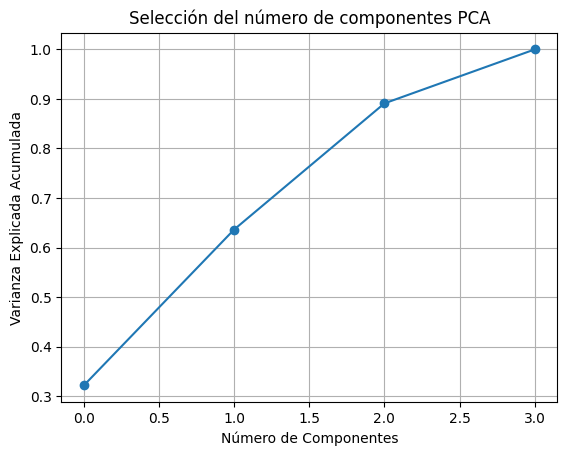

In [179]:
varnum2 = ['edad_usuario','hora_retiro_hour','tiempo_trayecto','dia_semana_num']
X = dfCirc_clean[varnum]
pca = PCA()
pca.fit(X)

# Graficar varianza explicada acumulada
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Selección del número de componentes PCA")
plt.grid()
plt.show()


In [180]:
pca = PCA(n_components=3)
X_pca = pca.fit(X)


cargas_pca = pd.DataFrame(pca.components_, columns=[f"Var{i+1}" for i in range(X.shape[1])], index=[f"PC{i+1}" for i in range(3)])

# Mostrar las cargas de los 5 primeros componentes
print(cargas_pca)

         Var1      Var2      Var3      Var4
PC1  0.324148 -0.663139  0.067939  0.671237
PC2 -0.474017  0.502182  0.020190  0.722989
PC3  0.818618  0.553819 -0.002978  0.152120


### Interpretacion

* componente 1: media ponderada edad usuario - hora retiro + día de la semana
* componente 2: - media (estacion retiro + hora retiro)
* componente 3: estacion_num - hora retiro + diasem 

In [209]:
X = dfCirc_clean[varnum]
X

,genero_num,edad_usuario,estacion_num,hora_retiro_hour,tiempo_trayecto,dia_semana_num
0,0.510515,-1.026357,1.428954,1.970642,-0.424818,-0.118680
1,0.510515,-0.327210,0.080978,1.970642,0.307908,-0.118680
2,0.510515,-0.764177,-0.647786,1.970642,1.722365,-0.118680
3,0.510515,1.770231,0.728769,-2.284058,-0.663022,0.383459
4,0.510515,0.808904,-0.080969,-2.284058,-0.302026,0.383459
...,...,...,...,...,...,...
51443,-1.571814,-0.065030,-0.604918,1.970642,-0.632156,1.387737
51444,0.510515,0.022363,-1.052655,1.970642,0.871544,1.387737
51445,0.510515,0.371937,-0.500128,1.970642,0.553492,1.387737
51446,-1.571814,-0.414603,1.247954,1.970642,0.087822,1.387737


# Clustering 

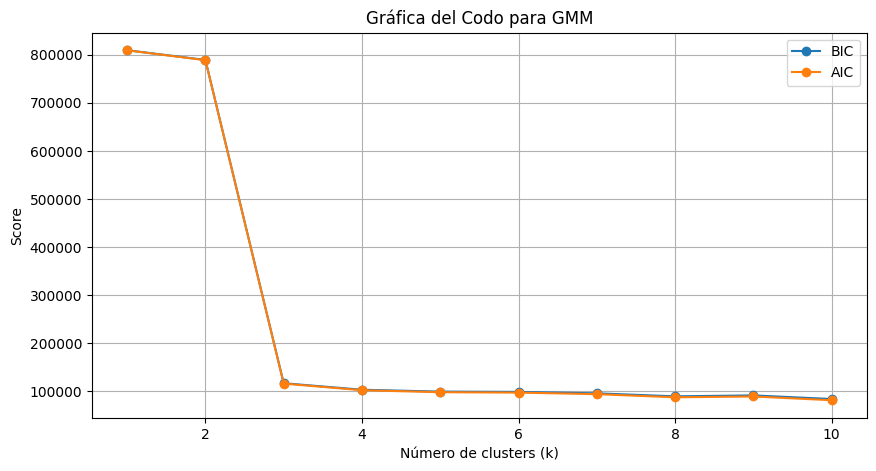

In [210]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np

bic = []
aic = []

K_range = range(1, 11)

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)
    bic.append(gmm.bic(X))
    aic.append(gmm.aic(X))
   

plt.figure(figsize=(10, 5))
plt.plot(K_range, bic, label='BIC', marker='o')
plt.plot(K_range, aic, label='AIC', marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Score")
plt.title("Gráfica del Codo para GMM")
plt.legend()
plt.grid(True)
plt.show()


In [211]:
from sklearn.metrics import silhouette_score, silhouette_samples

best_k = 3  # elige el que observes mejor en el gráfico del codo
gmm = GaussianMixture(n_components=best_k, random_state=42)
cluster_labels = gmm.fit_predict(X)

# Silhouette
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"Puntaje de Silueta promedio: {silhouette_avg:.4f}")


Puntaje de Silueta promedio: 0.2081


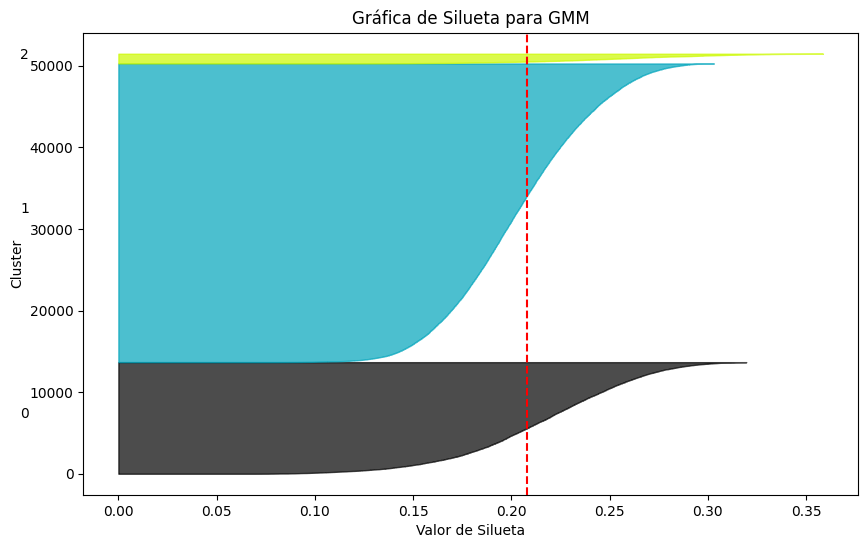

In [212]:

sample_silhouette_values = silhouette_samples(X, cluster_labels)

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(best_k):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / best_k)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Valor de Silueta")
plt.ylabel("Cluster")
plt.title("Gráfica de Silueta para GMM")
plt.show()


ValueError: 'c' argument has 51448 elements, which is inconsistent with 'x' and 'y' with size 52231.

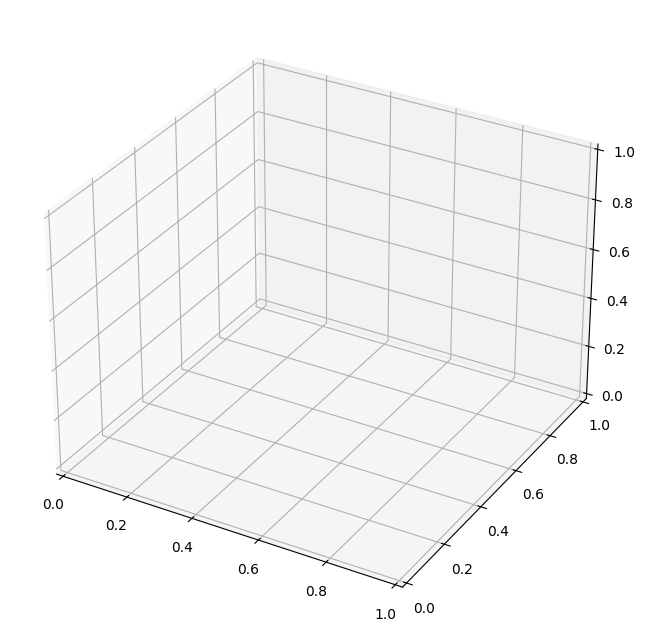

In [216]:
 #Crear la gráfica 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos en 3D, con color según los clusters
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=cluster_labels, cmap='viridis', s=50)

# Títulos y etiquetas
ax.set_title("Visualización 3D de Clusters usando PCA")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.view_init(elev=30, azim=180)
# Agregar una barra de color para los clusters
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Mostrar la gráfica
plt.show()


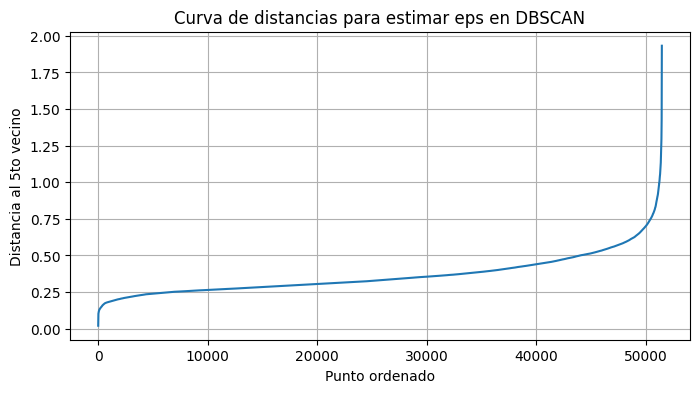

InvalidIndexError: (slice(None, None, None), 0)

<Figure size 600x600 with 0 Axes>

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import hdbscan

# Asumiendo que tienes X definido (shape: [n_samples, n_features])

# === DBSCAN ===
# Paso 1: Graficar las distancias k-vecinas para estimar un buen valor de eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, 4])  # el 5to vecino
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title("Curva de distancias para estimar eps en DBSCAN")
plt.xlabel("Punto ordenado")
plt.ylabel("Distancia al 5to vecino")
plt.grid(True)
plt.show()

# Paso 2: Ejecutar DBSCAN (ajusta eps según el gráfico anterior)
db = DBSCAN(eps=0.5, min_samples=5).fit(X)
labels_db = db.labels_

# Paso 3: Visualizar
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_db, cmap="tab10", s=10)
plt.title("DBSCAN clustering")
plt.show()

# === HDBSCAN ===
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
labels_hdb = clusterer.fit_predict(X)

# Visualizar HDBSCAN
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_hdb, cmap="tab10", s=10)
plt.title("HDBSCAN clustering")
plt.show()


# Clustering 

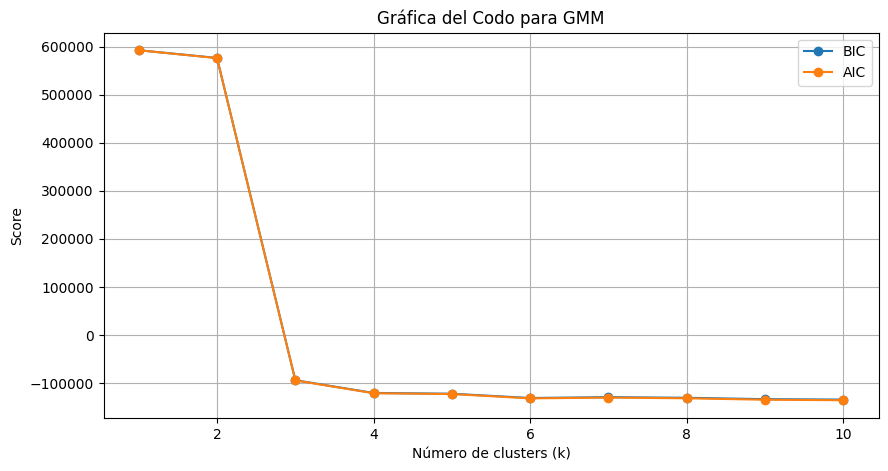

In [83]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np

bic = []
aic = []

K_range = range(1, 11)

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    bic.append(gmm.bic(X_scaled))
    aic.append(gmm.aic(X_scaled))
   

plt.figure(figsize=(10, 5))
plt.plot(K_range, bic, label='BIC', marker='o')
plt.plot(K_range, aic, label='AIC', marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Score")
plt.title("Gráfica del Codo para GMM")
plt.legend()
plt.grid(True)
plt.show()


In [84]:
from sklearn.metrics import silhouette_score, silhouette_samples

best_k = 3  # elige el que observes mejor en el gráfico del codo
gmm = GaussianMixture(n_components=best_k, random_state=42)
cluster_labels = gmm.fit_predict(X_scaled)

# Silhouette
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"Puntaje de Silueta promedio: {silhouette_avg:.4f}")


Puntaje de Silueta promedio: 0.2971


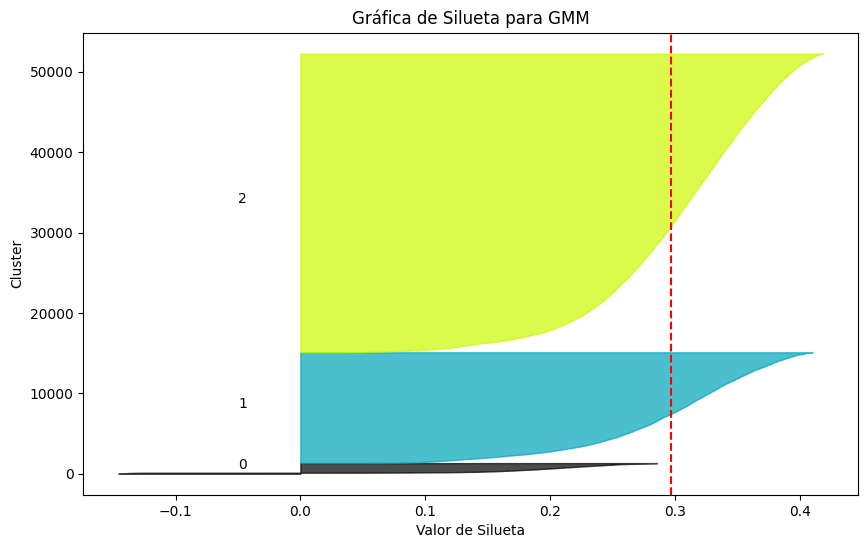

In [85]:
import matplotlib.cm as cm
import numpy as np

sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(best_k):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / best_k)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Valor de Silueta")
plt.ylabel("Cluster")
plt.title("Gráfica de Silueta para GMM")
plt.show()


# PCA


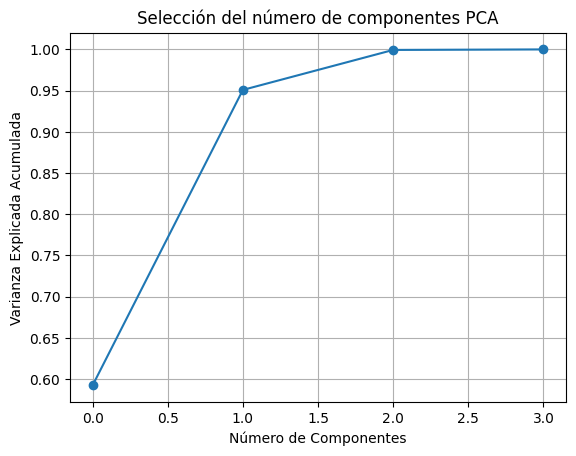

In [92]:
pca = PCA(n_components=3)
X_pca = pca.fit(X)


cargas_pca = pd.DataFrame(pca.components_, columns=[f"Var{i+1}" for i in range(X.shape[1])], index=[f"PC{i+1}" for i in range(3)])

# Mostrar las cargas de los 5 primeros componentes
print(cargas_pca)


         Var1      Var2      Var3      Var4
PC1  0.042993  0.998979 -0.013795 -0.001515
PC2  0.998410 -0.043459 -0.035821  0.002493
PC3  0.036384  0.012233  0.999263  0.000296


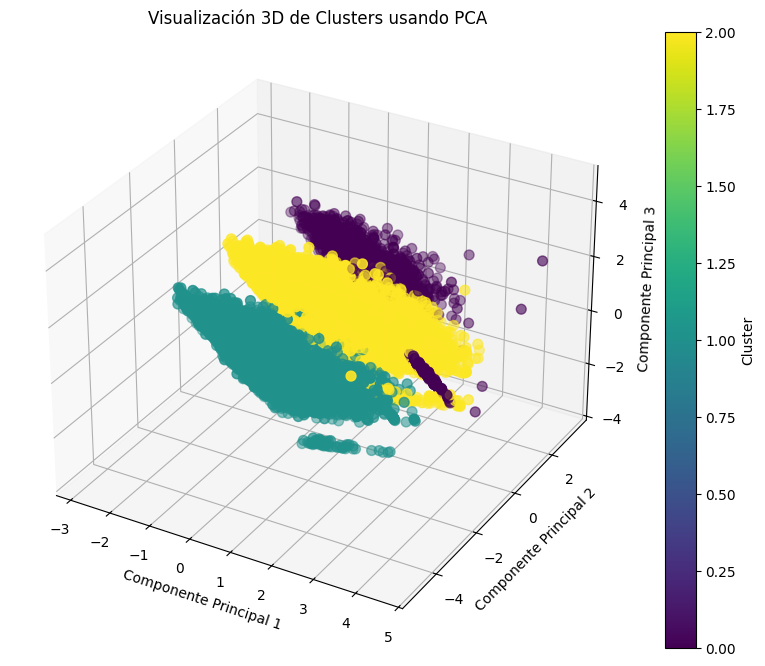

In [96]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reducir a 3 componentes principales
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Crear la gráfica 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos en 3D, con color según los clusters
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=cluster_labels, cmap='viridis', s=50)

# Títulos y etiquetas
ax.set_title("Visualización 3D de Clusters usando PCA")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")

# Agregar una barra de color para los clusters
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Mostrar la gráfica
plt.show()


In [97]:
X

,edad_usuario,tiempo_trayecto,hora_retiro_hour,genero_num
20,23.0,12.883333,23,1
175,25.0,5.150000,0,1
232,24.0,10.050000,0,1
285,31.0,31.083333,23,1
329,25.0,20.300000,0,0
...,...,...,...,...
1829705,34.0,7.733333,23,0
1829726,35.0,45.083333,23,1
1829728,39.0,37.183333,23,1
1829758,30.0,25.616667,23,0
